In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.0 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
from torchmetrics import Accuracy
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import imageio
import os
import random

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda:0


# Utilizar el modelo pre-entrenado VGG19 para clasificar el dataset

## Preprocesar y preparar los datos

In [ ]:
# Definir transform para transformar las imgs a Tensores con tamanho  normalizados en rango que VGG acepta como entrada, 224x224
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(32, padding=4),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
## Cargar y Aplicar transformaciones a las imagenes, desde los datasets que ofrece pytorch
##  El conjunto de datos Food101 consta de imágenes en color de 300x200 píxeles, divididas en 101 categorias
# En este caso sera un subconjunto del dataset editado previamente, para trabajar con 10 clases solamente
# Definir la ruta de la carpeta donde se encuentran las imágenes
images_folder = '/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/Dataset/images'

# Cargar el conjunto de datos de entrenamiento
image_dataset = torchvision.datasets.ImageFolder(root=images_folder, transform=transform)
# image_dataset = torchvision.datasets.ImageFolder(root=images_folder)

# Dividir el conjunto
train_size = int(0.6 * len(image_dataset))
eval_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - eval_size

train_dataset, eval_dataset, test_dataset = random_split(image_dataset, [train_size, eval_size, test_size])

# Crear un dataloader para cargar las imágenes en lotes
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, num_workers=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)


#### Este apartado es la definición utilizada para seleccionar de todo el dataset solo las imágenes donde las primeras 10 clases sean de mayor accuracy y guardarlas en la nube propia de drive. En el resto del notebook no se especifica su uso para resumir el largo y directamente se utilizan las carpetas guardadas. Para su uso se entrena primero VGG19 en todo el conjunto de datos y se utiliza este modelo guardado y la lista de clases guardadas tambien.

In [ ]:
import os
import shutil
# name_dataset debe ser = 'train' o 'test'
def reduce(model,dir_new_folder,name_dataset):
  dataset = datasets.Food101(root='./data', split = name_dataset, download=True, transform=transform)
  loader = DataLoader(dataset, batch_size=32, num_workers=2, shuffle=False)
  model.to(device)
  model.eval()
  all_predictions = []
  all_labels = []
  with torch.no_grad():
      for inputs, labels in loader:
          inputs = inputs.to(device)
          outputs = model(inputs)
          probabilities = F.softmax(outputs, dim=1)
          _, predicted = torch.max(probabilities, 1)
          all_predictions.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Calcular la precisión utilizando torchmetrics por cada clase con average=None y extraer las 10 mayores
  accuracy = Accuracy(task='MULTICLASS', num_classes=101, average=None)
  accuracy = accuracy(torch.tensor(all_predictions), torch.tensor(all_labels))
  accuracy, indices = torch.sort(accuracy, descending=True)
  top_classes = indices[:10]

  # Almacenar dataset completo
  food101_dataset = datasets.Food101(root='./', download=True)

  # Obtener los índices de las 10 clases con mayor precisión
  class_names = [food101_dataset.classes[i] for i in top_classes]


  print(len(os.listdir('./food-101/images')))
  # Definir la ruta de la carpeta donde se encuentran las imágenes
  images_folder = './food-101/images'

  # Eliminar las carpetas de las clases que no están en las 10 clases con mayor precisión
  for class_folder in os.listdir(images_folder):
      if class_folder not in class_names:
          shutil.rmtree(f'{images_folder}/{class_folder}')

  # Definir la ruta de la carpeta donde se desea mover la carpeta food-101 o utilizar el parametro
  # dir_new_folder = '/content/gdrive/My Drive/....'

  # Mover la carpeta food-101 a la nueva ubicación
  shutil.move(images_folder, dir_new_folder)

Nota: En caso de querer cargar a partit de carpetas ya dividads y con imágenes ya redimensionadas, ir a la celda de más abajo: Crear nuevos DataLoader a partir del Dataset filtrado y guardado. Y utilizar este para un nuevo proceso de entrenamiento u otro seg'un los objetivos

## Guardar/Obtener nombre de las clases

In [ ]:
# Obtener la lista de nombres de las clases
classes = np.array(train_dataset.classes)
# Guardar la lista en un archivo
np.save("/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/Dataset/class_names(2).npy", classes)

In [ ]:
# Cargar los nombres de las clases de Food101
classes = np.load("/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/Dataset/class_names(5).npy")

# Los de VGG serian 1000
# weights = VGG19_Weights.DEFAULT
# clases = weights.meta["categories"]

## Definir funciones train, evaluate y test para los procesos de los modelos

In [ ]:
def train(model,dataloader,num_epochs):
  # Definir la funcion de perdida y de optimizacion BCELoss dio errores de cuda
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()

    for epoch in range(num_epochs):
      # Inicializar los valores que se van a ir guardando y calculando para imprimir
        running_loss = 0.0
        num_iterations = 0
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, (images, labels) in progress_bar:
            # Mover los datos a la GPU si es posible
            images,labels = images.to(device), labels.to(device)
            # Reiniciar los gradientes
            optimizer.zero_grad()

            # Pasar los datos de entrada por la red
            outputs = model(images)
            # Forward pass: Calcular la pérdida y realizar el backpropagation
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Acumular la pérdida promedio por epoch
            running_loss += loss.item()
            num_iterations += 1

            # Imprimir estadísticas
            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs}, Loss: {(running_loss / num_iterations):.5f}")
            running_loss = 0.0

        progress_bar.close()

    print('\nTraining completed')

In [ ]:
def evaluate(model,dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        progress_bar = tqdm(dataloader, total=len(dataloader))
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            progress_bar.set_description(f"Evaluación")
        progress_bar.close()

    # Calcular la precisión utilizando torchmetrics
    accuracy = Accuracy(task='MULTICLASS', num_classes=5)
    accuracy = accuracy(torch.tensor(all_predictions), torch.tensor(all_labels))

    print(f"\nEvaluate Accuracy: {(float(accuracy) * 100):.2f}%\n")


In [ ]:
def test(model,dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        progress_bar = tqdm(dataloader, total=len(dataloader))
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            progress_bar.set_description(f"Test")
        progress_bar.close()

    # Calcular la precisión utilizando torchmetrics
    accuracy = Accuracy(task='MULTICLASS', num_classes=5)
    accuracy = accuracy(torch.tensor(all_predictions), torch.tensor(all_labels))
    print(f"\nTest Accuracy: {(float(accuracy) * 100):.2f}%")

## Cargar el modelo

In [ ]:
# Cargar el modelo VGG19 preentrenado con la última capa modificada
model = models.vgg19_bn(pretrained=True)
model.classifier[6] = nn.Linear(4096, 5)  # con 1 para utilizarBCEL dio errores de cuda
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:06<00:00, 89.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Entrenar, evaluar y probar modelo. Guardarlo en la nube  

In [ ]:
# Entrenar el modelo
train(model,train_loader,5)

In [ ]:
# Evaluar el modelo en el conjunto de evaluación
evaluate(model,eval_loader)

In [ ]:
# Probar el modelo en el conjunto de prueba
test(model,test_loader)

In [ ]:
# Guardar modelo entrenado
torch.save(model, '/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/modelCompleteVGG19_2.pth')

## Clasificar el conjunto de imágenes completo y obtener nuevos Datasets sin las imágenes mal clasificadas

In [ ]:
# Devuelve un nuevo dataset a partir de los argumentos sin las imágenes mal clasificadas
def classify_and_get_new_dataset(dataloader,name,batch_size):
    model = torch.load('/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/modelCompleteVGG19_5.pth', map_location=device)
    all_predictions = []
    all_labels = []
    indices = list(range(len(dataloader.dataset)))
    count = 0

    with torch.no_grad():
        for j, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            for i in range(len(inputs)):
                    if predicted[i] != labels[i]:
                      #  Indices i,j, donde i es la posicion de la imagen en el batch y j el batch en el dataloader
                      count+=1
                      #print(f'Eliminar indices {i} {j} => {i + (batch_size * j)}')
                      indices.remove(i + (batch_size * j))
                      #print(f'Image ID: {i},{j}, Real Label: {classes[labels[i]]}, Prediction: {classes[predicted[i]]}')

   # Calcular la precisión utilizando torchmetrics
    accuracy = Accuracy(task='MULTICLASS', num_classes=5)
    accuracy = accuracy(torch.tensor(all_predictions), torch.tensor(all_labels))
    print(f"\nAccuracy of {name} set clasification: {(float(accuracy) * 100):.2f}%")

    new_dataset = torch.utils.data.Subset(dataloader.dataset, indices)

    print(f'\nBefore: {len(dataloader.dataset)}')
    print(f'\nAfter: {len(new_dataset)}')
    print(f'\nNumber of errors: {count}')

    # Guardar el dataset
    torch.save(new_dataset, f'/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/All_Datasets(pth)/{name}Set_Dataset(5).pth')

    return new_dataset

Nota:

Para consultar una imagen específica del dataset según su clase es: classes[dataset[index][1]].

Para eliminar índices de la lista se utilizó remove(valor) ya que pop(index) elimina el valor del índice y los números de los índices se van corriendo en el proceso de eliminación.

Los índices de la imagen i,j, significan: i=posición de la imagen en el batch y j=el batch en el dataloader. Por tanto la posicion de la imagen i del dataloader j en el dataset en general será i + (batch_size * j)

La nueva función classify_and_get_new_dataset necesita:

- El dataloader del que va a eliminar las imágenes.
- El nombre del conjunto o dataset para mayor claridad en la salida.

Retorna el nuevo dataset sin las imágenes que el modelo clasificó incorrectamente, por tanto, la evaluación en este nuevo conjunto de datos tendrá un Accuracy de 100%

In [ ]:
# Se debe cargar el loader del dataset de train que no tenga los indices e imagenes mezclados aleatoriamente (30 min aprox)
# Se puede utilizar los dataloaders nuevos a partir del return o se puede cargar el archivo en una ejecucion que no es completa
train_loader_NoShuffled = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=False)
new_train_dataset = classify_and_get_new_dataset(train_loader_NoShuffled,'Training',32)
new_train_loader = DataLoader(new_train_dataset, batch_size=32,num_workers=2, shuffle=True)

new_eval_dataset = classify_and_get_new_dataset(new_eval_loader,'Evaluation',32)
new_eval_loader =  DataLoader(new_eval_dataset, batch_size=32,num_workers=2, shuffle=False)

new_test_dataset = classify_and_get_new_dataset(new_test_loader,'Testing',32)
new_test_loader  =  DataLoader(new_test_dataset, batch_size=32,num_workers=2, shuffle=False)


Accuracy of Training set clasification: 100.00%

Before: 2951

After: 2951

Number of errors: 0

Accuracy of Evaluation set clasification: 98.01%

Before: 1006

After: 986

Number of errors: 20

Accuracy of Testing set clasification: 97.72%

Before: 964

After: 942

Number of errors: 22


In [ ]:
# Comprobar (demora todo aprox 30min)
# model = torch.load('/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/modelCompleteVGG19.pth', map_location=device)
# evaluate(model,new_train_loader)
# evaluate(model,new_eval_loader)
# evaluate(model,new_test_loader)

## Guardar carpetas del nuevo dataset

In [ ]:
def classify_and_save_dataset(dataloader, name):
   # Crear una carpeta para guardar las imágenes clasificadas
  save_folder = f'/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/FilteredDataset_5/{name}'
  os.makedirs(save_folder, exist_ok=True)
  # Iterar sobre el nuevo dataset y guardar las imágenes en las carpetas correspondientes
  for j, (inputs,labels) in enumerate(dataloader):
    inputs,labels = inputs.to(device),labels.to(device)
    for i in range(len(inputs)):
      image_folder = os.path.join(save_folder, f'{classes[labels[i]]}')
      os.makedirs(image_folder, exist_ok=True)
      image_path = os.path.join(image_folder, f'{i + (32 * j)}.jpg')
      imjpg = (inputs[i].permute(1, 2, 0).cpu().detach().numpy() * 255).astype('uint8')
      imageio.imwrite(image_path, imjpg)


In [ ]:
classify_and_save_dataset(new_train_loader,'TrainingSet')
classify_and_save_dataset(new_eval_loader,'EvaluationSet')
classify_and_save_dataset(new_test_loader,'TestingSet')

In [ ]:
os.listdir('/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/FilteredDataset_5/EvaluationSet')

['french_fries', 'guacamole', 'macarons', 'pizza', 'spaghetti_bolognese']

# Definir y utilizar red en cascada a partir de dos redes neuronales combinadas

## Crear nuevos DataLoader a partir del Dataset filtrado y guardado

In [17]:
# Dataset_2   Dataset_5  FilteredDataset_10
train_dataset = datasets.ImageFolder(root='/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/FilteredDataset_2/TrainingSet/',transform = transforms.ToTensor())
eval_dataset = datasets.ImageFolder(root='/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/FilteredDataset_2/EvaluationSet/',transform = transforms.ToTensor())
test_dataset = datasets.ImageFolder(root='/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/FilteredDataset_2/TestingSet/',transform = transforms.ToTensor())

new_train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=2)
new_eval_loader = DataLoader(eval_dataset, batch_size=5, shuffle=False, num_workers=2)
new_test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
# # Otra via
# train_dataset = torch.load('/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/TrainingSet_Dataset(5).pth')
# new_train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)

# eval_dataset = torch.load('/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/EvaluationSet_Dataset(5).pth')
# new_eval_loader = DataLoader(eval_dataset, batch_size=32, num_workers=2, shuffle=False)

# testset = torch.load('/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/TestingSet_Dataset10.pth')
# new_test_loader = DataLoader(testset, batch_size=32, num_workers=2, shuffle=False)


In [33]:
print(f'Size of trainDataSet: {len(train_dataset)}')
print(f'Size of evalDataSet: {len(eval_dataset)}')
print(f'Size od testDataSet: {len(test_dataset)}')
print(f'Num_total_batch:{len(new_train_loader)}')

Size of trainDataSet: 755
Size of evalDataSet: 766
Size od testDataSet: 400
Num_total_batch:151


## Definir red explicadora
#### Esta red debe tomar imágenes como entrada, procesarlas y aplicar una función definida que modifique los píxeles de acuerdo con sus respectivas relevancias, cuyos pesos se actualizarán a medida que se entrene la red en general

In [34]:
# Pruebas de cosas para mejoras en visualizacion
# print(f'\nIMAGEN ORIGINAL:')
# imshow(x[0])
# filtro_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# mapa = y.view(-1,3,224,224)
# mapa = filtro_transform(y.view(-1, 3,224,224))
# print(f'\nMAPA DE IMPORTANCIA:')
# imshow(mapa[0])

# print(f'\nRESALTADO:')
# filtro_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# y_copy = filtro_transform(y.view(-1, 3,224,224))
# y_copy = y_copy.reshape(-1,3*224*224)
# ej = x*y_copy
# ej = ej.view(-1, 3, 224, 224)
# imshow(ej[0])

# print(f'\nGRAYSCALE:')
# grayscale_transform = transforms.Grayscale(num_output_channels=3)
# y_bn = grayscale_transform(y.view(-1, 3,224,224))
# y_bn = y_bn.reshape(-1, 3*224*224)
# ej = x* y_bn
# ej = ej.view(-1, 3, 224, 224)
# imshow(ej[0])

# FUNCIONES
# x = x+x*(1-y)
# x = x * torch.pow(y, 0.8-y)
# x*(1+y-0.7)


In [46]:
# Arquitectura simple con 2 capas lineales
class ExplainerNetwork(nn.Module):
  def __init__(self):
    super(ExplainerNetwork, self).__init__()
    self.fc1 = nn.Linear(3*224*224,1200)  # 3*224*224=150528 y 150528/2=75264
    self.fc2 = nn.Linear(1200, 3*224*224)

  def forward(self, x):
    # Flattern
    x = x.view(-1, 3*224*224)
    # Capas densas
    y = F.relu(self.fc1(x))
    y = F.sigmoid(self.fc2(y))
    # Perturbacion
    x = x*y
    # Reshape
    x = x.view(-1,3,224,224)
    return x

## Cargar el clasificador entrenado
#### Se utiliza la salida de la primera red como entrada para la segunda red, la cual es un modelo ya entrenado que se carga y se configura como una capa congelada, lo que significa que sus pesos no se modificarán durante el entrenamiento de la red en general

In [6]:
Classifier_Network = torch.load('/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/modelCompleteVGG19_2.pth', map_location=device)

## Combinar ambas redes: Definir red en cascada
#### Los pesos de una red neuronal son valores numéricos que se ajustan durante el proceso de entrenamiento de la red. Cada peso representa la importancia o contribución de una entrada en la salida de la red. La combinación de estas redes consiste en que la primera aprenda sobre los pesos de la segunda, de forma que pueda mostrar los píxeles más importantes para esta.

In [7]:
class CombinedNetwork(nn.Module):
    def __init__(self, explainer_network, classifier_network):
        super(CombinedNetwork, self).__init__()
        self.explainer_network = explainer_network
        self.classifier_network = classifier_network

    def forward(self, x):
        # Pasar datos de entrada por la primera red
        y = self.explainer_network(x)

        # Pasar datos de entrada por la segunda red
        x = self.classifier_network(y)

        return x

## Función para mostrar las imágenes

In [8]:
def imshow(image):
    # image = transforms.Grayscale()(image) pal blanco y negro
    # Convierte el tensor a un arreglo NumPy
    image = image.cpu().detach().numpy()

    # Reordena las dimensiones del tensor para ser compatible con plt.imshow
    image = np.transpose(image, (1, 2, 0))

    # Crea una figura y un conjunto de subplots
    fig, ax = plt.subplots(nrows=1, ncols=1, squeeze=False, sharex=True, sharey=True)

    # Muestra la imagen en el primer subplot
    ax[0, 0].imshow(image, vmin=0, vmax=1)
    ax[0, 0].axis('off')

    # Muestra los subplots
    plt.show()

In [9]:
# images = [(image1, "Imagen 1"), (image2, "Imagen 2"), (image3, "Imagen 3")]
def show_images(images,message):
    # Crea una figura con subplots
    fig, axs = plt.subplots(1, len(images), figsize=(10, 10))

    # Muestra cada imagen en un subplot diferente
    for i, (image, name) in enumerate(images):
        image=image.cpu().detach().numpy()
        image = np.transpose(image, (1, 2, 0))
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(name)
    axs[-1].text(0, image.shape[1] + 10, message, fontsize=10, ha='right')

    # Muestra los subplots
    plt.show()

## Entrenar, evaluar y probar la red en cascada

In [10]:
def train(model,dataloader,num_epochs):
  # Definir la funcion de perdida y de optimizacion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.explainer_network.parameters(), lr=0.001, momentum=0.9)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    losses = []

    for epoch in range(num_epochs):
      # Inicializar los valores que se van a ir guardando y calculando para imprimir
        running_loss = 0.0
        loss_epoch = 0.0
        num_iterations = 0
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, (images, labels) in progress_bar:
            # Mover los datos a la GPU si es posible
            images, labels = images.to(device), labels.to(device)
            # Reiniciar los gradientes
            optimizer.zero_grad()

            # Pasar los datos de entrada por la red
            outputs = model(images)

            # Forward pass: Calcular la pérdida y realizar el backpropagation
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Acumular la pérdida promedio por epoch
            running_loss += loss.item()
            num_iterations += 1

            # Imprimir estadísticas
            loss_epoch = running_loss / num_iterations
            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs}, Loss: {(loss_epoch):.5f}")
            running_loss = 0.0
        losses.append(loss_epoch)
        progress_bar.close()

    plt.plot(range(1, len(losses) + 1), losses, label='Training Loss', linewidth=2,markersize=3, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('\nTraining completed')

In [48]:
# Crear una instancia de la red neuronal ExplainerNetwork
Explainer_Network = ExplainerNetwork().to(device)

In [49]:
combined_network = CombinedNetwork(Explainer_Network, Classifier_Network).to(device)

Epoch 4/4, Loss: 0.00026: 100%|██████████| 151/151 [00:31<00:00,  4.83it/s]


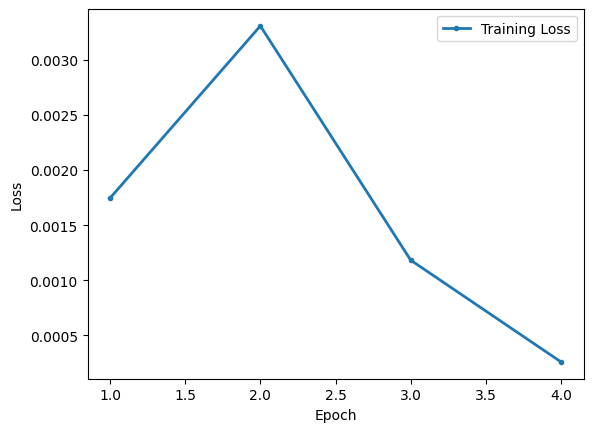


Training completed


In [50]:
# Se utilizan las mismas funciones definidas en el apartado anterior
train(combined_network,new_train_loader,4)

In [35]:
def save(combined_network,loader):
  combined_network.eval()

  # Lista para almacenar los resultados por cada imagen
  resultados = []

  # Iterar sobre el conjunto de datos de validación
  with torch.no_grad():  # Asegurarse de que no estamos realizando el seguimiento de gradientes
      for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        # Pasar las imágenes a través de la red explicadora (ExplainerNetwork)
        exp_fc1 = combined_network.explainer_network.fc1(images.view(-1, 3*224*224))
        exp_fc2 = F.sigmoid(combined_network.explainer_network.fc2(exp_fc1))
        # exp_fc2 = exp_fc2.view(-1,3,224,224)
        exp_output = combined_network.explainer_network(images.view(-1, 3*224*224))

        # Obtener la predicción del modelo clasificador
        pred = combined_network.classifier_network(images)

        # Almacenar los resultados en el diccionario
        for i in range(len(labels)):
          resultado = {
              'Etiqueta': labels[i],
              'Imagen_Original': images[i],
              'Mapa_Relevancia': exp_fc2[i],
              'Imagen_Perturbada': exp_output[i],
              'Prediccion': torch.argmax(pred[i]).item()
          }
          resultados.append(resultado)

  return resultados

In [43]:
resultados = save(combined_network,new_eval_loader) # demmoro 3min

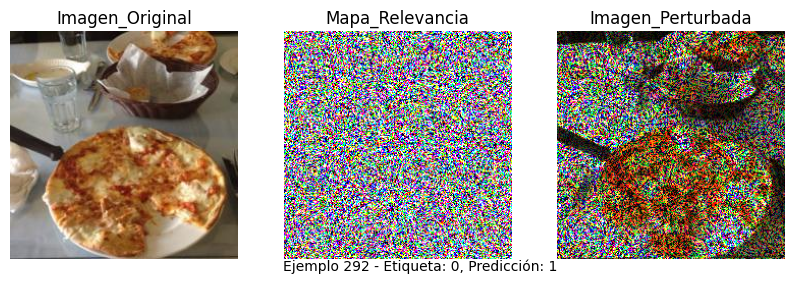

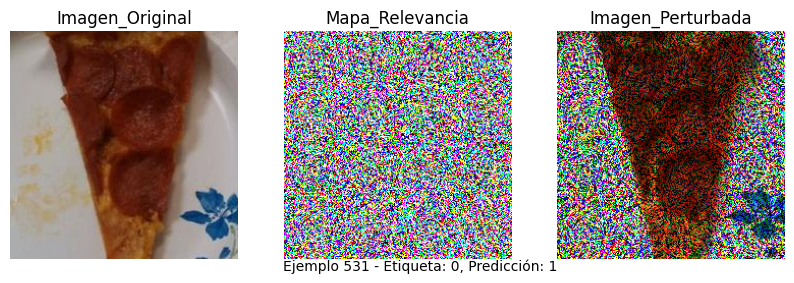

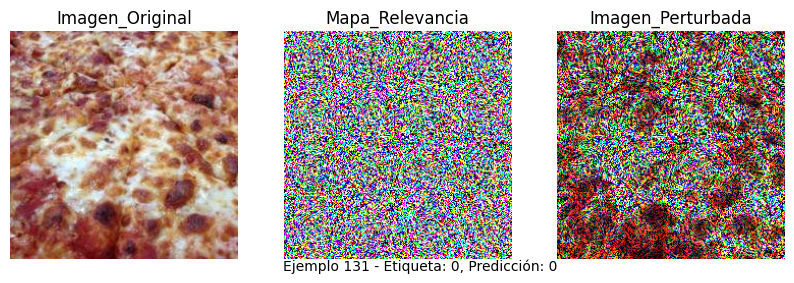

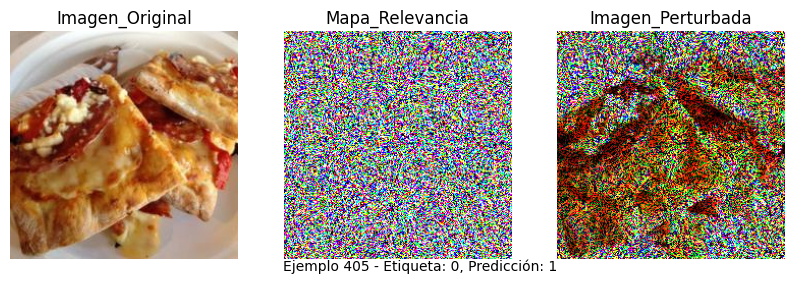

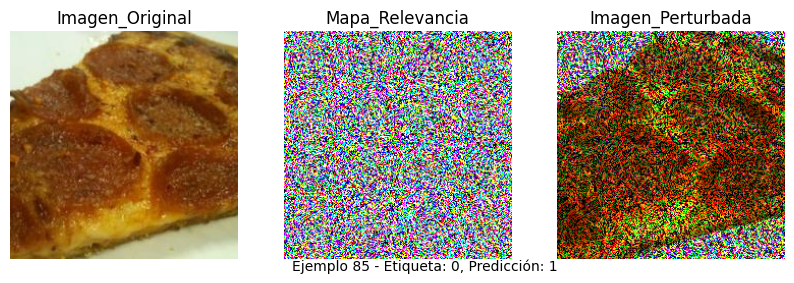

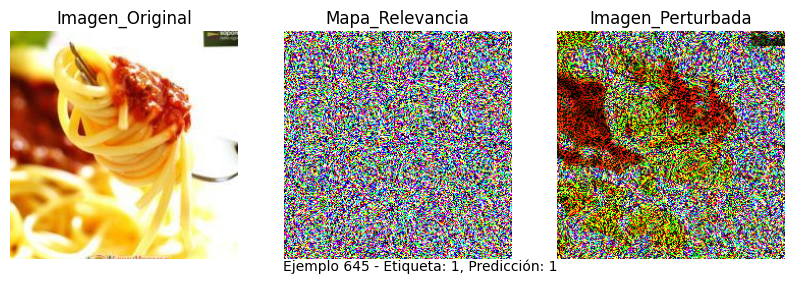

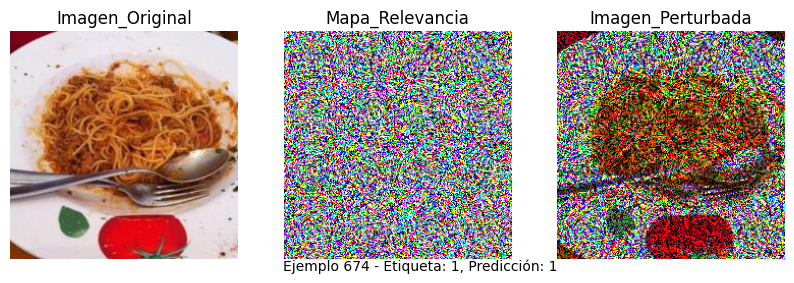

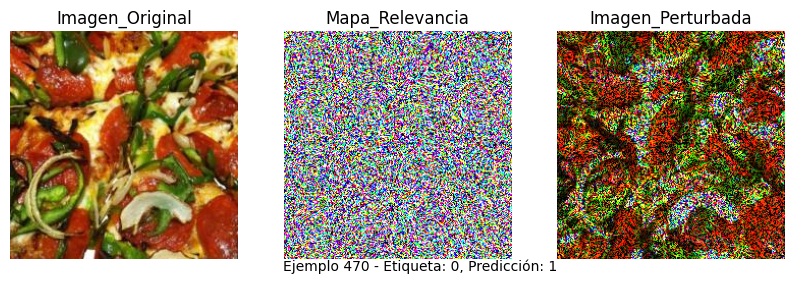

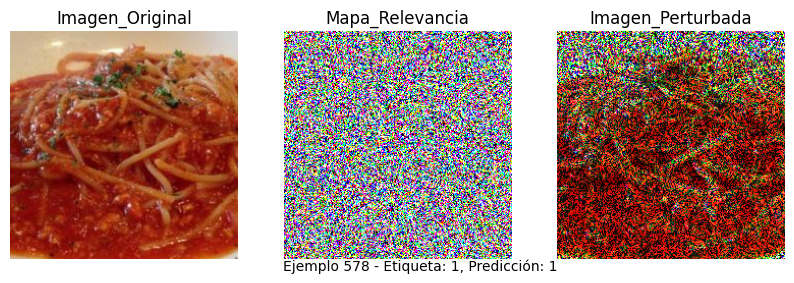

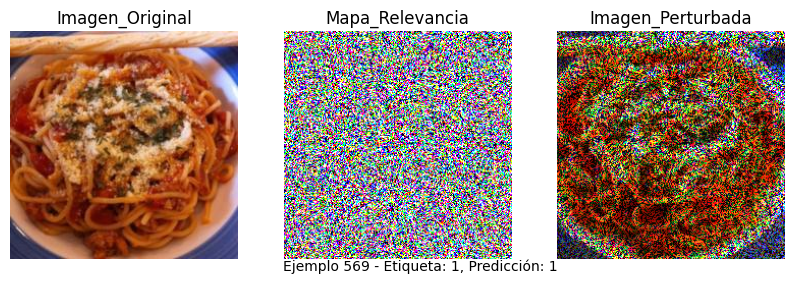

In [45]:
# Obtener 10 índices aleatorios
indices_aleatorios = random.sample(range(len(resultados)), min(10, len(resultados)))

# Mostrar algunos ejemplos usando imshow
for i in indices_aleatorios:
    message = (f"Ejemplo {i+1} - Etiqueta: {resultados[i]['Etiqueta'].item()}, Predicción: {resultados[i]['Prediccion']}")
    # Debido a que se capturan los valores numéricos del mapa de relevancia en un vector para si futuramente se quiere capturar estos valores
    # es necesario convertir el vector en imagen para mostrarla
    aux = (resultados[i]['Mapa_Relevancia']*2).view(3,224,224)
    images = [(resultados[i]['Imagen_Original'], 'Imagen_Original'), (aux, 'Mapa_Relevancia'), (resultados[i]['Imagen_Perturbada'], 'Imagen_Perturbada')]
    show_images(images,message)

In [51]:
# Guardar modelo entrenado
torch.save(Explainer_Network, '/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/Explainer_Network_VGG19(2).pth')

In [52]:
import pickle
# Guardar el diccionario en un archivo
# El de 10 no se pudo guardar por el uso de memoria
with open('/content/gdrive/My Drive/Colab Notebooks/TesisNotebooks/result_VGG19(5).pkl', 'wb') as archivo:
    pickle.dump(resultados, archivo)